<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [ ]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")



Episode 1: total reward = -793
Episode 2: total reward = -694
Episode 3: total reward = -2080
Episode 4: total reward = -892
Episode 5: total reward = -397


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



In [ ]:

import gymnasium as gym
import numpy as np
from tqdm import tqdm

def sarsa(print_rewards=False, is_slippery=False):
  # Create the environment
  if is_slippery:
    env = gym.make("CliffWalking-v1", render_mode="ansi", is_slippery=True)
  else:
    env = gym.make("CliffWalking-v1", render_mode="ansi", is_slippery=False)


  n_episodes = 10000      # number of episodes to run
  max_steps = 100     # safety cap

  # Q-learning parameters
  learning_rate = 0.1
  epsilon = 0.01
  discount_factor = 0.99
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions))

  rewards = []
  def get_e_greedy_action(e):
      epsilon_loc = e
      def get_action(q_loc, env_loc, state_loc):
          if np.random.random() < epsilon_loc:
              return env_loc.action_space.sample()
          else:
              return np.argmax(q_loc[state])
      return get_action


  actin_selector = get_e_greedy_action(e=epsilon)

  for episode in range(n_episodes):
      done = False
      total_reward = 0
      state, info = env.reset()
      action = actin_selector(Q, env, state)

      for step in range(max_steps):
        next_state, reward, terminated, truncated, info = env.step(action)
        next_action = actin_selector(Q, env, state)
        Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * Q[next_state, next_action] - Q[state, action])
        state, action = next_state, next_action
        total_reward += reward


        if terminated or truncated:
            break

      if print_rewards:
        print(f"Episode {episode+1}: total reward = {total_reward}")
      rewards.append(total_reward)
  return Q, rewards, n_actions
sarsa_Q, sarsa_rewards, n_actions = sarsa(True, False)

Streaming output truncated to the last 5000 lines.
Episode 5001: total reward = -20
Episode 5002: total reward = -20
Episode 5003: total reward = -20
Episode 5004: total reward = -20
Episode 5005: total reward = -20
Episode 5006: total reward = -20
Episode 5007: total reward = -20
Episode 5008: total reward = -20
Episode 5009: total reward = -20
Episode 5010: total reward = -20
Episode 5011: total reward = -20
Episode 5012: total reward = -20
Episode 5013: total reward = -20
Episode 5014: total reward = -20
Episode 5015: total reward = -22
Episode 5016: total reward = -20
Episode 5017: total reward = -20
Episode 5018: total reward = -20
Episode 5019: total reward = -20
Episode 5020: total reward = -20
Episode 5021: total reward = -20
Episode 5022: total reward = -20
Episode 5023: total reward = -20
Episode 5024: total reward = -20
Episode 5025: total reward = -100
Episode 5026: total reward = -19
Episode 5027: total reward = -19
Episode 5028: total reward = -19
Episode 5029: total rewa

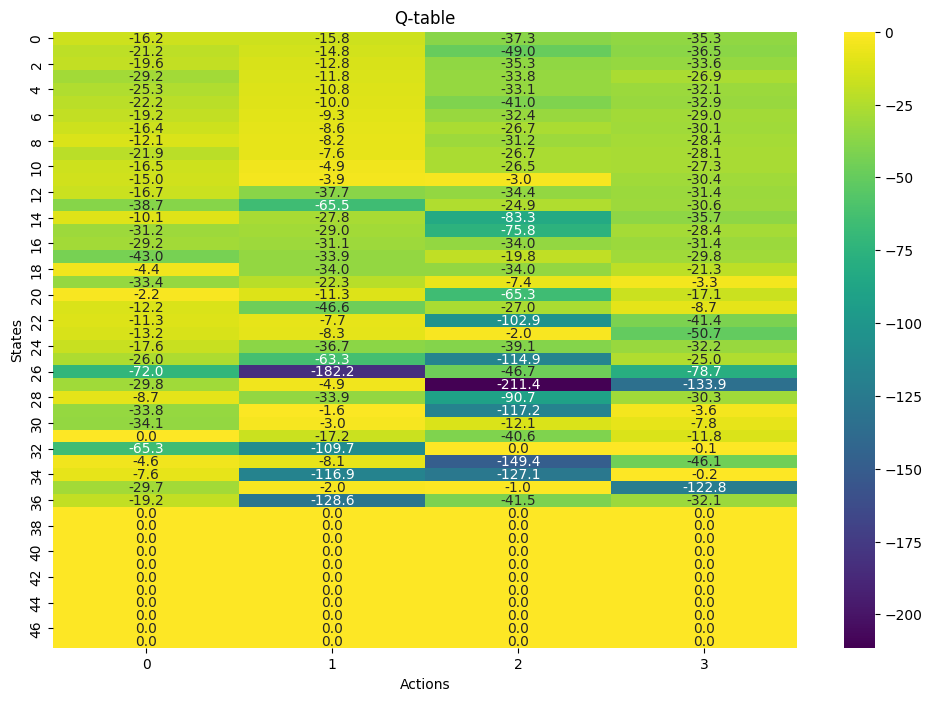

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(sarsa_Q)

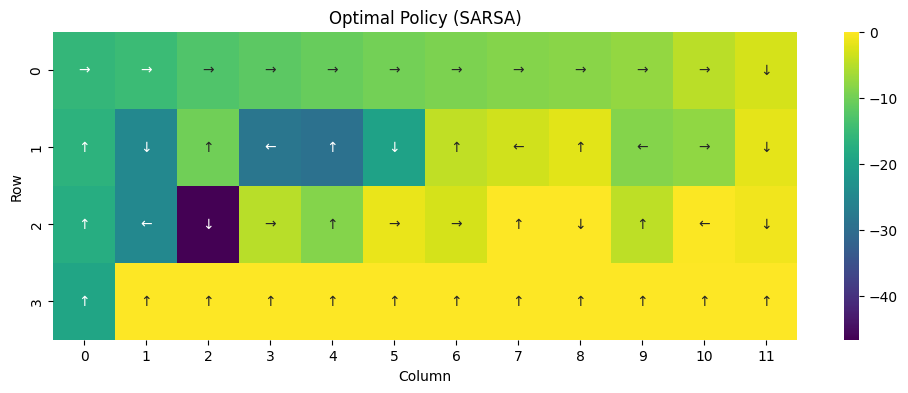

In [ ]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (SARSA)")
  plt.show()
plot_policy(sarsa_Q)

## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [ ]:

import gymnasium as gym
import numpy as np
from tqdm import tqdm


def qlearning(print_rewards=False, is_slippery=False):
  # Create the environment
  if is_slippery:
    env = gym.make("CliffWalking-v1", render_mode="ansi", is_slippery=True)
  else:
    env = gym.make("CliffWalking-v1", render_mode="ansi")

  n_episodes = 10000      # number of episodes to run
  max_steps = 100     # safety cap

  # Q-learning parameters
  learning_rate = 0.1
  epsilon = 0.01
  discount_factor = 0.99
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions))
  rewards = []
  def get_e_greedy_action(e):
      epsilon_loc = e
      def get_action(q_loc, env_loc, state_loc):
          if np.random.random() < epsilon_loc:
              return env_loc.action_space.sample()
          else:
              return np.argmax(q_loc[state])
      return get_action


  actin_selector = get_e_greedy_action(e=epsilon)

  for episode in range(n_episodes):
      done = False
      total_reward = 0
      state, info = env.reset()

      for step in range(max_steps):
        action = actin_selector(Q, env, state)
        next_state, reward, terminated, truncated, info = env.step(action)
        Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state]) - Q[state, action])
        state = next_state
        total_reward += reward

        if terminated or truncated:
            break
      if print_rewards:
        print(f"Episode {episode+1}: total reward = {total_reward}")
      rewards.append(total_reward)
  return Q, rewards, n_actions
qlearning_Q, qlearning_rewards, n_actions = qlearning(True, False)

Streaming output truncated to the last 5000 lines.
Episode 5001: total reward = -13
Episode 5002: total reward = -13
Episode 5003: total reward = -13
Episode 5004: total reward = -13
Episode 5005: total reward = -13
Episode 5006: total reward = -13
Episode 5007: total reward = -20
Episode 5008: total reward = -13
Episode 5009: total reward = -13
Episode 5010: total reward = -13
Episode 5011: total reward = -13
Episode 5012: total reward = -13
Episode 5013: total reward = -13
Episode 5014: total reward = -13
Episode 5015: total reward = -13
Episode 5016: total reward = -13
Episode 5017: total reward = -13
Episode 5018: total reward = -13
Episode 5019: total reward = -13
Episode 5020: total reward = -13
Episode 5021: total reward = -13
Episode 5022: total reward = -13
Episode 5023: total reward = -13
Episode 5024: total reward = -15
Episode 5025: total reward = -13
Episode 5026: total reward = -13
Episode 5027: total reward = -13
Episode 5028: total reward = -13
Episode 5029: total rewar

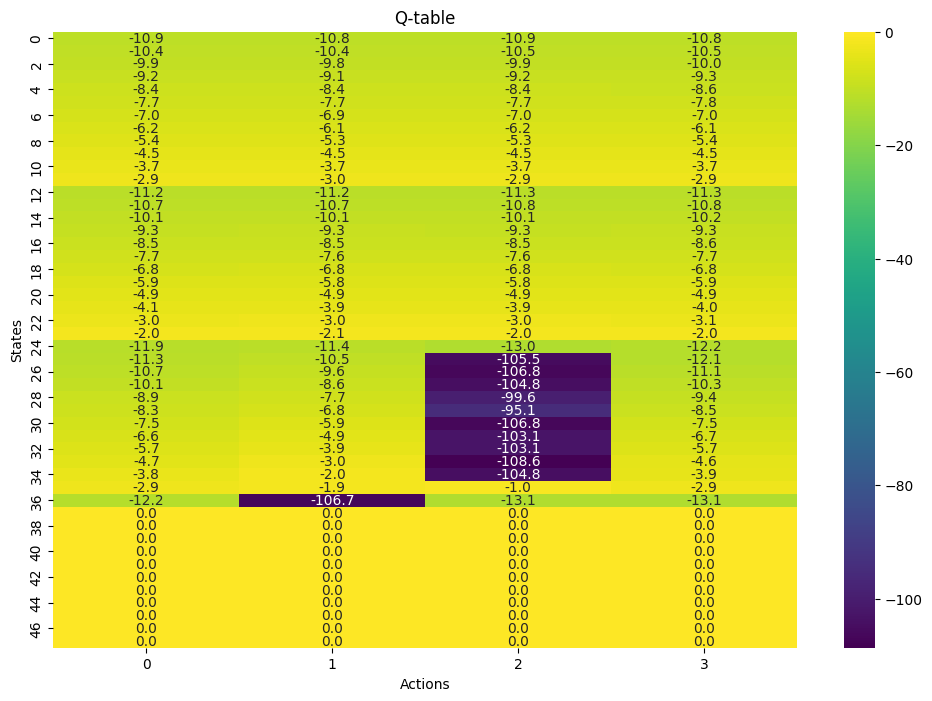

In [ ]:
plot_Q(qlearning_Q)

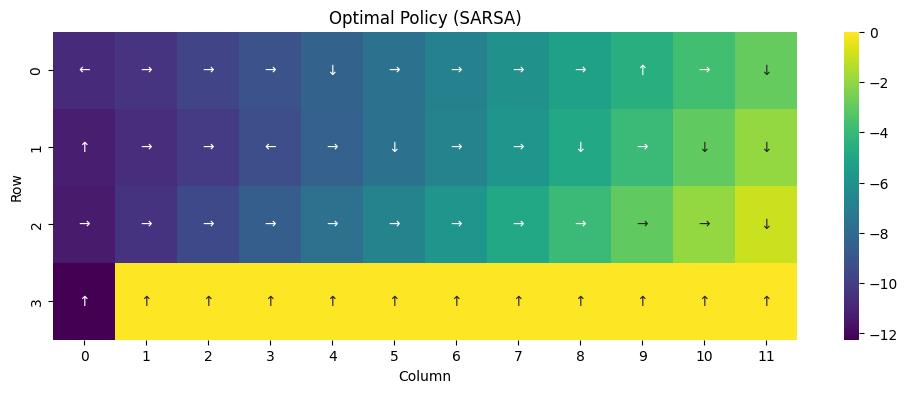

In [ ]:
plot_policy(qlearning_Q, "Q-Learning")

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


In [ ]:
import plotly.express as px
import pandas as pd

def plot_linearly(input_dict: dict, trend_window: int):
  df = pd.DataFrame.from_dict(input_dict)
  if trend_window:
    for col in df.columns:
      df[col] = df[col].rolling(window=trend_window).mean()
  fig = px.line(df, x=df.index, y=df.columns.tolist(), title='Comparing total reward trends between QLearning and SARSA')
  fig.show()

qlearning_Q, qlearning_rewards, n_actions = qlearning(False)
sarsa_Q, sarsa_rewards, n_actions = sarsa(False)
qlearning_Q_is, qlearning_rewards_is, n_actions = qlearning(False, is_slippery=True)
sarsa_Q_is, sarsa_rewards_is, n_actions = sarsa(False, is_slippery=True)
plot_linearly({'qlearning': qlearning_rewards, 'sarsa': sarsa_rewards, 'qlearning_is': qlearning_rewards_is, 'sarsa_is': sarsa_rewards_is}, trend_window=5)


# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?


episode: 0
[[ 0.   0.  -0.1 -0.1]
 [ 0.   0.  -0.1  0. ]
 [ 0.  -0.1 -0.1  0. ]
 [ 0.  -0.1  0.   0. ]]


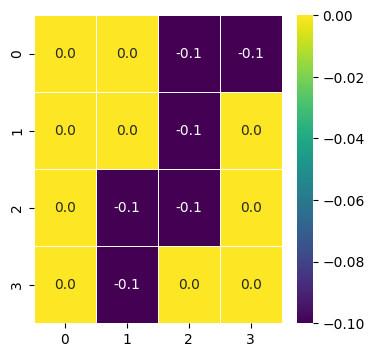

episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
[[ 0.         -0.32383729 -0.4685041  -0.53663239]
 [-0.1099     -0.271      -0.32728538 -0.36271   ]
 [-0.19       -0.1999     -0.1999     -0.19      ]
 [-0.19       -0.1999     -0.1         0.        ]]


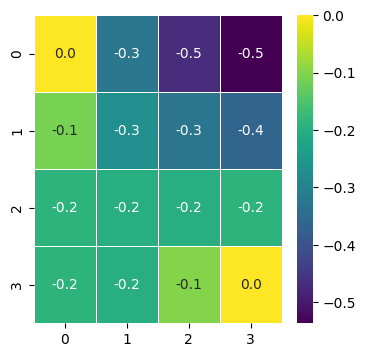

episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
[[ 0.         -0.63312931 -0.77141563 -0.76175461]
 [-0.22760119 -0.43364399 -0.5055292  -0.49001188]
 [-0.29872    -0.31671722 -0.2997001  -0.271     ]
 [-0.30058219 -0.28981    -0.19        0.        ]]


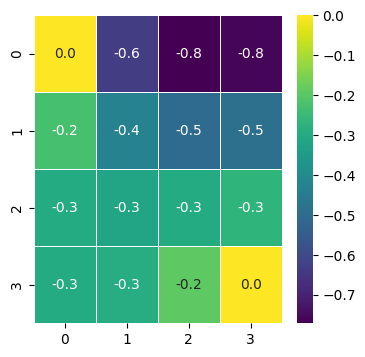

episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
[[ 0.         -0.77351894 -1.04869707 -1.06981341]
 [-0.3439     -0.55635975 -0.74216616 -0.77435436]
 [-0.395677   -0.42193291 -0.48914028 -0.468559  ]
 [-0.40009725 -0.379639   -0.2997001   0.        ]]


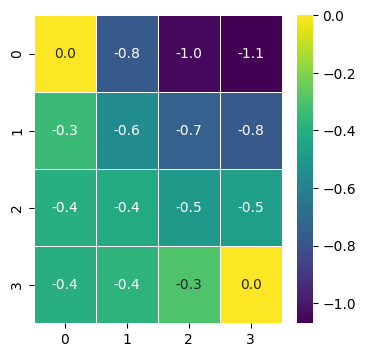

episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
[[ 0.         -0.87842335 -1.20538228 -1.33208622]
 [-0.40951    -0.72738405 -0.90587876 -0.94580558]
 [-0.4901554  -0.58800564 -0.61433898 -0.611645  ]
 [-0.49925955 -0.48024809 -0.38150119  0.        ]]


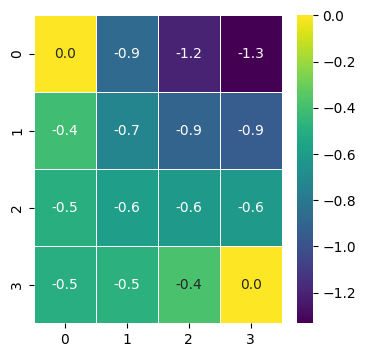

episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
[[ 0.         -0.9282102  -1.40724805 -1.62118541]
 [-0.48003945 -0.77224301 -1.01057951 -1.14104458]
 [-0.57887703 -0.652914   -0.70078883 -0.68040973]
 [-0.57077713 -0.54025342 -0.45109725  0.        ]]


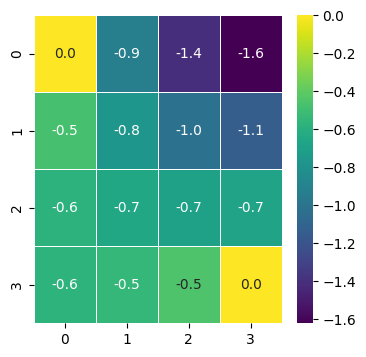

episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
[[ 0.         -0.96184796 -1.5270206  -1.70912491]
 [-0.5217031  -0.88240066 -1.12489571 -1.2269875 ]
 [-0.67103712 -0.74579102 -0.836362   -0.74581342]
 [-0.68031981 -0.65332339 -0.56953279  0.        ]]


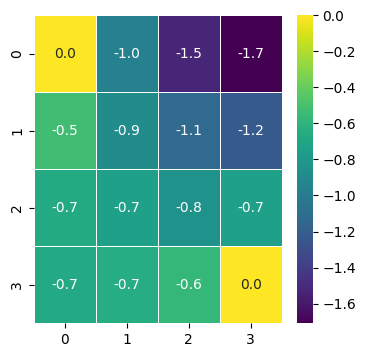

episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
[[ 0.         -0.9835768  -1.67764609 -1.8684696 ]
 [-0.56953279 -0.89621087 -1.23395293 -1.35636571]
 [-0.67103712 -0.74579102 -0.87098959 -0.77123208]
 [-0.68031981 -0.65332339 -0.56953279  0.        ]]


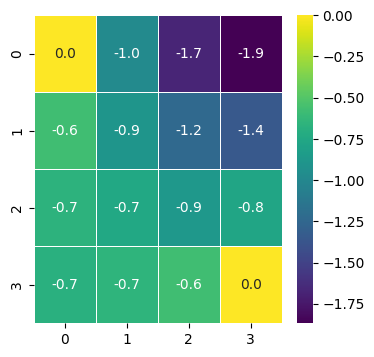

episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
[[ 0.         -0.99293035 -1.73024723 -1.96262359]
 [-0.56953279 -0.89621087 -1.24663584 -1.40111004]
 [-0.67103712 -0.74579102 -0.87098959 -0.81469798]
 [-0.68031981 -0.65332339 -0.56953279  0.        ]]


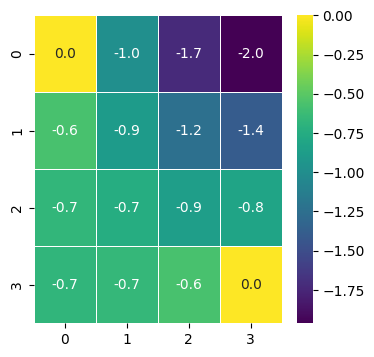

episode: 81
episode: 82
episode: 83
episode: 84
episode: 85
episode: 86
episode: 87
episode: 88
episode: 89
episode: 90
[[ 0.         -0.99726107 -1.74599964 -2.00507112]
 [-0.61257951 -0.89925359 -1.28016678 -1.43598978]
 [-0.68637062 -0.83105882 -0.87302419 -0.81469798]
 [-0.68031981 -0.65332339 -0.56953279  0.        ]]


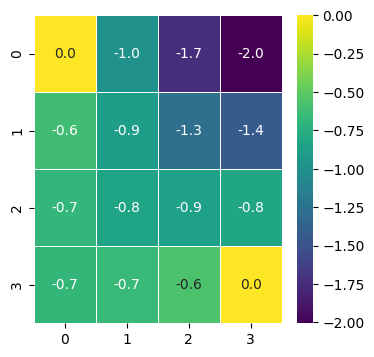

episode: 91
episode: 92
episode: 93
episode: 94
episode: 95
episode: 96
episode: 97
episode: 98
episode: 99
episode: 100
[[ 0.         -0.99854442 -1.80330843 -2.08456248]
 [-0.612772   -0.98254914 -1.34708545 -1.48441598]
 [-0.68637062 -0.83105882 -0.95772394 -0.84990536]
 [-0.68031981 -0.65332339 -0.57352723  0.        ]]


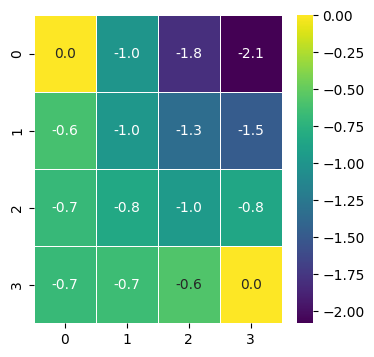

episode: 101
episode: 102
episode: 103
episode: 104
episode: 105
episode: 106
episode: 107
episode: 108
episode: 109
episode: 110
[[ 0.         -0.9993038  -1.86710196 -2.20587922]
 [-0.612772   -0.98254914 -1.4006937  -1.57406755]
 [-0.68637062 -0.85697229 -0.96653028 -0.89058101]
 [-0.68031981 -0.67121455 -0.57352723  0.        ]]


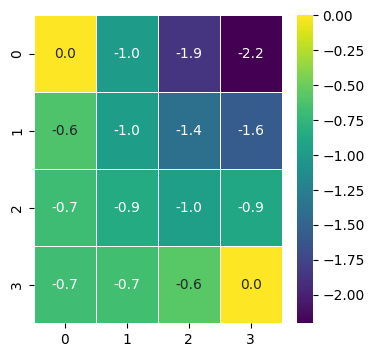

episode: 111
episode: 112
episode: 113
episode: 114
episode: 115
episode: 116
episode: 117
episode: 118
episode: 119
episode: 120
[[ 0.         -0.99966701 -1.89035712 -2.36173325]
 [-0.612772   -1.01187365 -1.4222433  -1.68450134]
 [-0.76031715 -0.91263195 -0.96653028 -0.92023356]
 [-0.76057219 -0.73402952 -0.57352723  0.        ]]


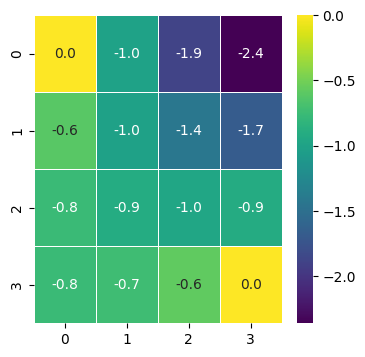

episode: 121
episode: 122
episode: 123
episode: 124
episode: 125
episode: 126
episode: 127
episode: 128
episode: 129
episode: 130
[[ 0.         -0.99984073 -1.93107039 -2.39450081]
 [-0.61673769 -1.06913448 -1.50832519 -1.72833171]
 [-0.76031715 -0.91263195 -1.04422637 -0.93538918]
 [-0.76057219 -0.73402952 -0.62358779  0.        ]]


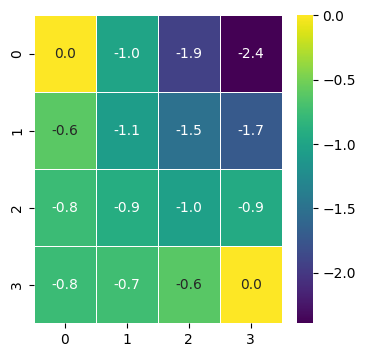

episode: 131
episode: 132
episode: 133
episode: 134
episode: 135
episode: 136
episode: 137
episode: 138
episode: 139
episode: 140
[[ 0.         -0.9999383  -1.96988308 -2.47635798]
 [-0.61673769 -1.06913448 -1.51228251 -1.74810206]
 [-0.76031715 -0.91263195 -1.04422637 -0.93540561]
 [-0.76057219 -0.73402952 -0.62358779  0.        ]]


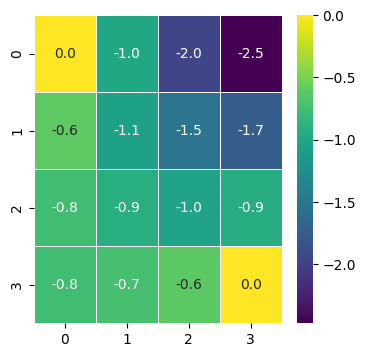

episode: 141
episode: 142
episode: 143
episode: 144
episode: 145
episode: 146
episode: 147
episode: 148
episode: 149
episode: 150
[[ 0.         -0.99996356 -1.97797543 -2.56457361]
 [-0.71757046 -1.09074803 -1.52977391 -1.79863241]
 [-0.85737137 -0.97203943 -1.08463617 -0.95760884]
 [-0.879897   -0.82236176 -0.65132156  0.        ]]


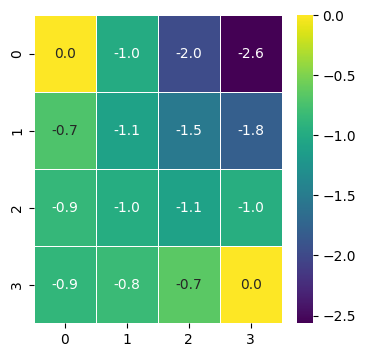

episode: 151
episode: 152
episode: 153
episode: 154
episode: 155
episode: 156
episode: 157
episode: 158
episode: 159
episode: 160
[[ 0.         -0.99998432 -1.98288937 -2.61388951]
 [-0.71757046 -1.09074803 -1.52977391 -1.81744531]
 [-0.85737137 -0.97203943 -1.08463617 -0.96566316]
 [-0.879897   -0.82236176 -0.65132156  0.        ]]


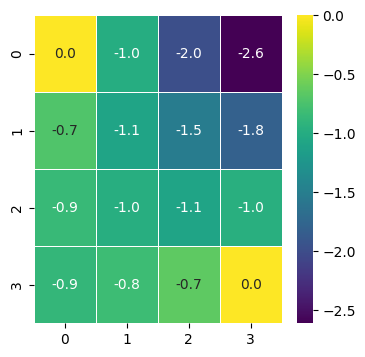

episode: 161
episode: 162
episode: 163
episode: 164
episode: 165
episode: 166
episode: 167
episode: 168
episode: 169
episode: 170
[[ 0.         -0.9999925  -1.984238   -2.66960508]
 [-0.71757046 -1.09074803 -1.52977391 -1.85694394]
 [-0.85737137 -0.97203943 -1.08463617 -0.97496844]
 [-0.879897   -0.82236176 -0.65132156  0.        ]]


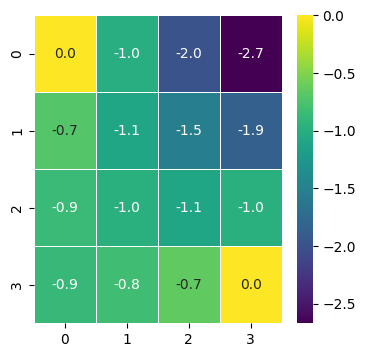

episode: 171
episode: 172
episode: 173
episode: 174
episode: 175
episode: 176
episode: 177
episode: 178
episode: 179
episode: 180
[[ 0.         -0.99999641 -1.98579803 -2.72784058]
 [-0.71757046 -1.09074803 -1.56711798 -1.88285729]
 [-0.85737137 -0.97203943 -1.11997103 -0.97972444]
 [-0.879897   -0.82236176 -0.6861894   0.        ]]


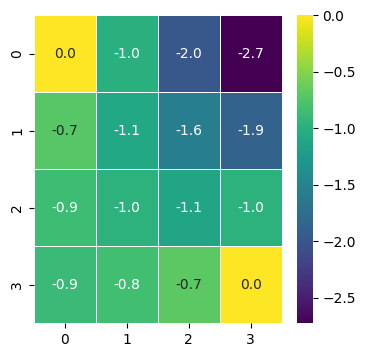

episode: 181
episode: 182
episode: 183
episode: 184
episode: 185
episode: 186
episode: 187
episode: 188
episode: 189
episode: 190
[[ 0.         -0.99999828 -1.98724229 -2.76913871]
 [-0.71757046 -1.09074803 -1.56711798 -1.90701528]
 [-0.85737137 -0.97203943 -1.11997103 -0.98521912]
 [-0.879897   -0.82236176 -0.6861894   0.        ]]


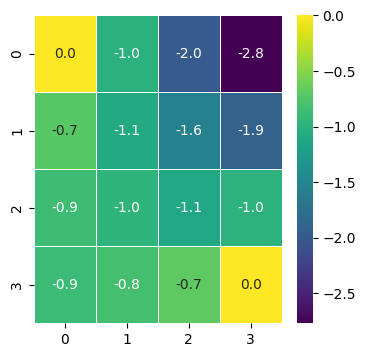

episode: 191
episode: 192
episode: 193
episode: 194
episode: 195
episode: 196
episode: 197
episode: 198
episode: 199


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


n_episods = 200
max_steps = 50
n = 4
actions = [0,1,2,3]
Q = np.zeros([n*n,len(actions)])
learning_rate = 0.1
epsilon = 0.01
discount_factor = 0.99

def go_step(state, action):
    row, col = divmod(state, n)
    if action == 0:  # up
        new_row, new_col = max(row - 1, 0), col
    elif action == 1:  # down
        new_row, new_col = min(row + 1, n - 1), col
    elif action == 2:  # left
        new_row, new_col = row, max(col - 1, 0)
    elif action == 3:  # right
        new_row, new_col = row, min(col + 1, n - 1)
    new_state = new_row * n + new_col
    reward = -1
    return new_state, reward

def get_e_greedy_action(e):
    epsilon_loc = e
    def get_action(q_loc, state_loc):
        if np.random.random() < epsilon_loc:
            return np.random.randint(len(actions))
        else:
            temp = q_loc[state_loc]
            return np.random.choice(np.flatnonzero(temp == temp.max()))
    return get_action


action_selector = get_e_greedy_action(e=epsilon)
for episode in range(n_episods):
  total_reward = 0
  state = np.random.randint(n)
  while state in [0, 16]:
      state = np.random.randint(n)
  print(f"episode: {episode}")
  action = action_selector(Q, state)

  for step in range(max_steps):

    #### Write your code here ######### SARSA
    state_next, r = go_step(state, action)
    action_next = action_selector(Q, state_next)
    Q[state, action] = Q[state, action] + learning_rate * (r + discount_factor * Q[state_next, action_next] - Q[state, action])
    if state_next in [0, n**2-1]:
      break
    state, action = state_next, action_next

    # ### Write your code here ######### Q-L
    # state_next, r = go_step(state, action)
    # action = action_selector(Q, state)
    # Q[state, action] = Q[state, action] + learning_rate * (r + discount_factor * np.max(Q[state_next]) - Q[state, action])
    # if state_next in [0, n**2-1]:
    #   break
    # state = state_next


  ###### PLOT
  # Reshape the 1D value function array into an 8x8 grid

  if not episode%10:
    V_grid = np.max(Q,axis=1).reshape([n, n])
    print(V_grid)

    # Plot the value function as a heatmap
    plt.figure(figsize=(4, 4))
    sns.heatmap(V_grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5)
    # plt.title("Value Function k=%d"%(k+1))
    # plt.xlabel("Column")
    # plt.ylabel("Row")
    plt.show()